# Task 3 - ZNE

Zero-noise extrapolation (ZNE) is a noise mitigation technique. It works by intentionally scaling the noise of a quantum circuit to then extrapolate the zero-noise limit of an observable of interest.

### Instructions

In this task, you will build a simple ZNE function from scratch:

1.   Build a simple noise model with depolarizing noise
2.  Create different circuits to test your noise models and choose the observable to measure  **#not done**
3.  Apply the unitary folding method.
4.  Apply the extrapolation method to get the zero-noise limit. Different extrapolation methods achieve different results, such as Linear, polynomial, and exponential. **apply poly_fir method**
5.  Compare mitigated and unmitigated results
6.  Bonus: Run your ZNE function in real quantum hardware through the **IBM Quantum Service**.

Check the [Mitiq documentation](https://mitiq.readthedocs.io/en/stable/guide/zne-5-theory.html) for references. You are not allowed to use the functions from Mitiq or any other frameworks where ZNE is already implemented.

### Deadline

1. 2 weeks from when you’ve submitted your application in your timezone.
2. Once you have finished a screening task, please submit your GitHub repository containing the code to this google form: [**LINK**](https://forms.gle/dJdYz74EYfwjSTzL9) -- **other forms of submission will not be accepted!**
3. If you have any questions - please add comments to this document, or ask it in the QOSF slack workspace (invitation link) in the #mentorship-applicants channel.
4. We will be updating this document with more details and/FAQ to avoid confusion, so make sure to check it before asking :)

##### Installing libraries and dependencies

In [1]:
!pip install pennylane
!pip install pennylane-qiskit
!pip install amazon-braket-pennylane-plugin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.6/249.6 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 20.7 MB/s eta 0:00:00
  Installing build dependencies .

##### ZNE

In [2]:
import pennylane as qml
import pennylane.numpy as np
from pennylane.transforms import mitigate_with_zne  # ZNE implementation using pennylane

from matplotlib import pyplot as plt

In [3]:
n_wires = 4
np.random.seed(1234)


# building our custom hamiltonian
coeffs = [1.0] * (n_wires - 1) + [0.5] * n_wires
observables = [qml.PauliX(i) @ qml.PauliX(i + 1) for i in range(n_wires - 1)]
observables += [qml.PauliZ(i) for i in range(n_wires)]

H = qml.Hamiltonian(coeffs, observables)

print(np.array(coeffs))
print("\n Hamiltonian =",H)

[1.  1.  1.  0.5 0.5 0.5 0.5]

 Hamiltonian =   (0.5) [Z0]
+ (0.5) [Z1]
+ (0.5) [Z2]
+ (0.5) [Z3]
+ (1.0) [X0 X1]
+ (1.0) [X1 X2]
+ (1.0) [X2 X3]


In [4]:
n_layers = 2

w1 = np.ones((n_wires), requires_grad=True)
w2 = np.ones((n_layers, n_wires - 1, 2), requires_grad=True)

print(np.shape(w2))

(2, 3, 2)


In [5]:
def ansatz(w1, w2):
    qml.SimplifiedTwoDesign(w1, w2, wires=range(n_wires))
    return qml.expval(H)

print(qml.draw(ansatz)(w1,w2))

0: ─╭SimplifiedTwoDesign─┤ ╭<𝓗>
1: ─├SimplifiedTwoDesign─┤ ├<𝓗>
2: ─├SimplifiedTwoDesign─┤ ├<𝓗>
3: ─╰SimplifiedTwoDesign─┤ ╰<𝓗>


Applying richardson's extrapolation for mitigation.

In [6]:
# Depolarizing noise
noise_gate = qml.DepolarizingChannel
noise_strength = 0.05

dev_ideal = qml.device("default.mixed", wires=n_wires)
dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength, position="all")

scale_factors=[1, 2, 3]

qnode_ideal = qml.QNode(ansatz, dev_ideal) # ideal qnode
qnode_noisy = qml.QNode(ansatz, dev_noisy) #noisy qnode
qnode_mitigated = mitigate_with_zne(qnode_noisy,
    scale_factors=scale_factors,
    folding=qml.transforms.fold_global,
    extrapolate=qml.transforms.richardson_extrapolate,
) # mitigated qnode

print("Ideal QNode: ", qnode_ideal(w1, w2))
print("Mitigated QNode: ", qnode_mitigated(w1, w2))
print("Noisy QNode: ", qnode_noisy(w1, w2))

Ideal QNode:  0.7786752842284947
Mitigated QNode:  0.6001417137223949
Noisy QNode:  0.30459632191309644


In the code below we prin the **folding schemes** for various types of global_folding scales in the vector scale_factors. For folding rep=0 the first circuit is basically unchanged. The second circuit has global_folding with 1 rep and the last circuit has global folding for 2 reps. This amplifies the noise levels. Below I have printed each to help visualize the circuits better.

[<QNode: wires=4, device='default.mixed', interface='auto', diff_method='best'>, <QNode: wires=4, device='default.mixed', interface='auto', diff_method='best'>, <QNode: wires=4, device='default.mixed', interface='auto', diff_method='best'>] 




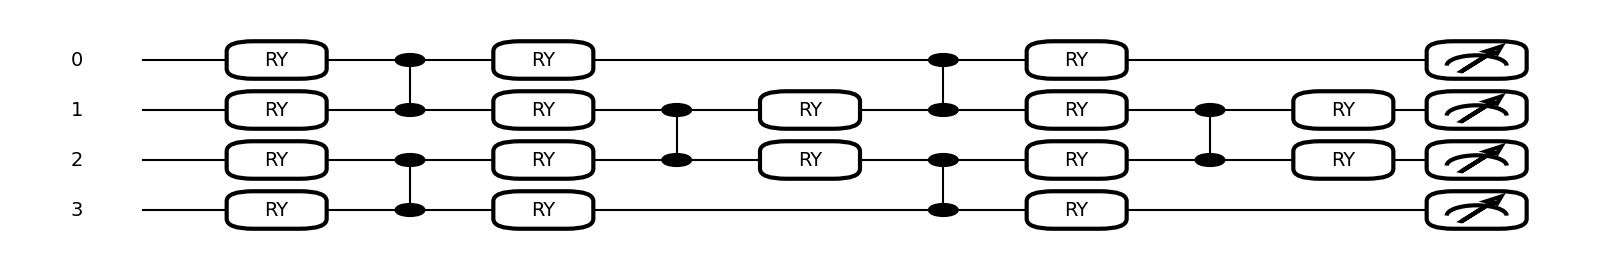

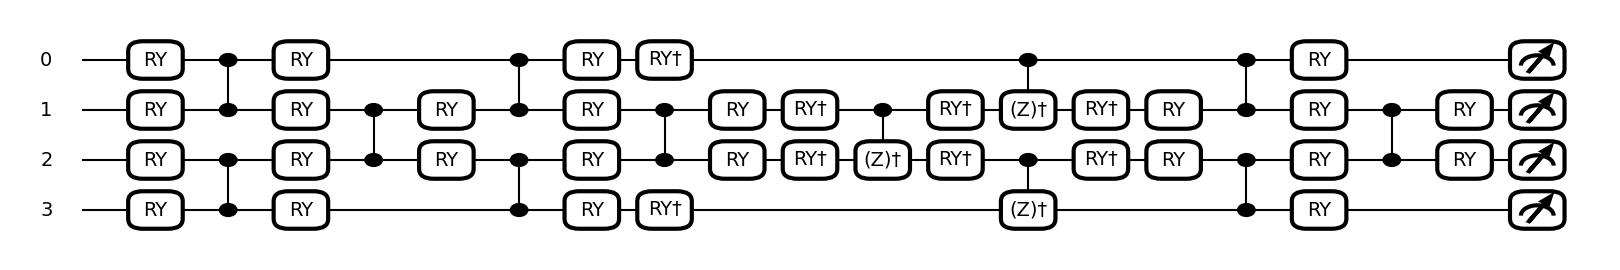

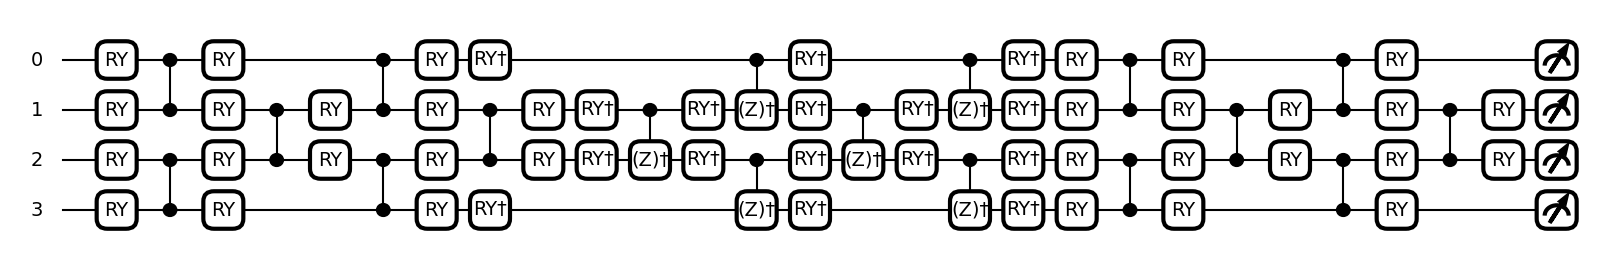

In [7]:
folded_circuits = [qml.transforms.fold_global(qnode_noisy, scale_factor) for scale_factor in scale_factors]
print(folded_circuits,"\n\n")

for i in range(len(folded_circuits)):
  drawing, ax = qml.draw_mpl(folded_circuits[i])(w1,w2)
  fig = drawing.figure
  fig.set_figwidth(16)
  fig.set_figheight(2.5)
  drawing.show()

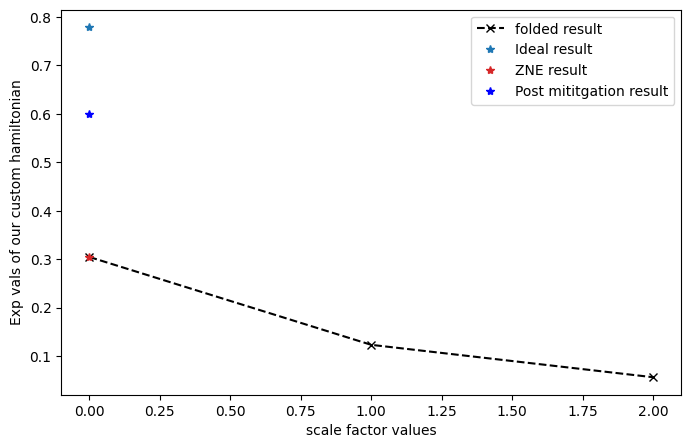

In [8]:
scale_factors = [1, 2, 3]
folded_res = [
    qml.transforms.fold_global(qnode_noisy, lambda_)(w1, w2) for lambda_ in scale_factors
]

ideal_res = qnode_ideal(w1, w2)
mitigated_res = qnode_mitigated(w1,w2)

coeffs = np.polyfit([scale_factor-1 for scale_factor in scale_factors], folded_res, 2)
zne_res = coeffs[-1]

x_fit = np.linspace(0, scale_factors[-1], 20)
y_fit = np.poly1d(coeffs)(x_fit)

plt.figure(figsize=(8, 5))
plt.plot([scale_factor-1 for scale_factor in scale_factors], folded_res, "x--", label="folded result",color="k")
plt.plot(0, ideal_res, "*", label="Ideal result")
plt.plot(0, zne_res, "*", label="ZNE result", color="tab:red")
plt.plot(0, mitigated_res, "*", label="Post mititgation result", color= "b")
plt.xlabel("scale factor values")
plt.ylabel("Exp vals of our custom hamiltonian")
plt.legend()
plt.show()

With each iteration of circuit folding the results keep getting worse as the noise increases

In [10]:
def VQE_run(cost_fn, max_iter, stepsize=0.1):
    """VQE Optimization loop"""
    opt = qml.SPSAOptimizer(maxiter= max_iter)

    # fixed initial guess
    w1 = np.ones((n_wires), requires_grad=True)
    w2 = np.ones((n_layers, n_wires - 1, 2), requires_grad=True)

    energy = []

    # Optimization loop
    for _ in range(max_iter):
        (w1, w2), prev_energy = opt.step_and_cost(cost_fn, w1, w2)

        energy.append(prev_energy)

    energy.append(cost_fn(w1, w2)) # final addition to the last updated params

    return energy # energy list


max_iter = 500

energy_ideal = VQE_run(qnode_ideal, max_iter)
energy_noisy = VQE_run(qnode_noisy, max_iter)
energy_mitigated = VQE_run(qnode_mitigated, max_iter)

energy_exact = np.min(np.linalg.eigvalsh(qml.matrix(H)))

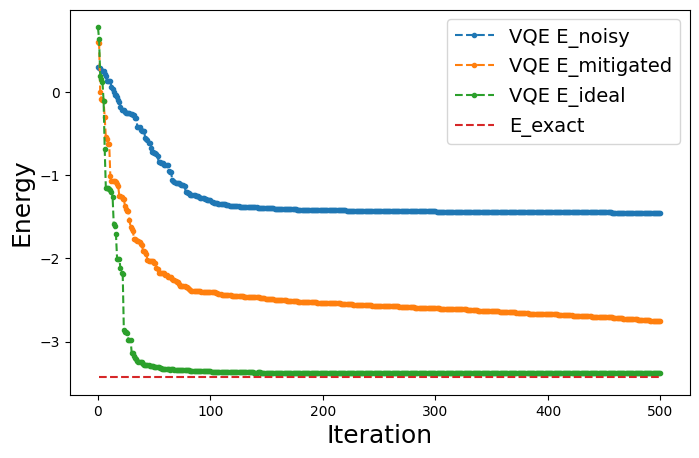

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(energy_noisy, ".--", label="VQE E_noisy")
plt.plot(energy_mitigated, ".--", label="VQE E_mitigated")
plt.plot(energy_ideal, ".--", label="VQE E_ideal")
plt.plot([1, max_iter + 1], [energy_exact] * 2, "--", label="E_exact")
plt.legend(fontsize=14)
plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Energy", fontsize=18)
plt.show()

Trying the polynomial extrapolation with a different hamiltonian.

Running our results against IBM Quantum Backend (real quantum hardware)